In [1]:
import sys,os,argparse,time
import numpy as np
import torch
import utils
from datetime import datetime
import pickle
from tabulate import tabulate
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Script to clean and structure the full dataset ready for training.
import random
import numpy as np
# Pandas used for loading and manipulating .csv files
import pandas as pd
# plotting using matplotlib
import matplotlib.pyplot as plt
# seaborn for fancy plotting (builds on top of matplotlib)
import seaborn as sn
sn.set()
from IPython.display import display
import os
import os,sys
import numpy as np
import torch
from torchvision import datasets,transforms

Populating the interactive namespace from numpy and matplotlib


/Users/jonastjomsland/anaconda3/envs/ucb/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Arguments
parser=argparse.ArgumentParser(description='xxx')
parser.add_argument('--seed',               default=0,              type=int,     help='(default=%(default)d)')
parser.add_argument('--device',             default='cpu',          type=str,     help='gpu id')
parser.add_argument('--experiment',         default='2 task groups',       type =str,    help='Mnist or dissertation')
parser.add_argument('--approach',           default='lul',          type =str,    help='Method, always Lifelong Uncertainty-aware learning')
parser.add_argument('--data_path',          default='data_cleaning/data.csv',     type=str,     help='gpu id')

# Training parameters
parser.add_argument('--output',             default='',             type=str,     help='')
parser.add_argument('--checkpoint_dir',     default='../checkpoints_2_tasks',    type=str,   help='')
parser.add_argument('--n_epochs',           default=100,              type=int,     help='')
parser.add_argument('--batch_size',         default=64,             type=int,     help='')
parser.add_argument('--lr',                 default=0.001,           type=float,   help='')
parser.add_argument('--hidden_size',        default=800,           type=int,     help='')
parser.add_argument('--parameter',          default='',             type=str,     help='')

# UCB HYPER-PARAMETERS
parser.add_argument('--MC_samples',         default='10',           type=int,     help='Number of Monte Carlo samples')
parser.add_argument('--rho',                default='-3',           type=float,   help='Initial rho')
parser.add_argument('--sigma1',             default='0.0',          type=float,   help='STD foor the 1st prior pdf in scaled mixture Gaussian')
parser.add_argument('--sigma2',             default='6.0',          type=float,   help='STD foor the 2nd prior pdf in scaled mixture Gaussian')
parser.add_argument('--pi',                 default='0.25',         type=float,   help='weighting factor for prior')

parser.add_argument('--resume',             default='no',           type=str,     help='resume?')
parser.add_argument('--sti',                default= 1,              type=int,     help='starting task?')

parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")

args=parser.parse_args()
utils.print_arguments(args)

Arguments =
	seed: 0
	device: cpu
	experiment: 2 task groups
	approach: lul
	data_path: data_cleaning/data.csv
	output: 
	checkpoint_dir: ../checkpoints_2_tasks
	n_epochs: 100
	batch_size: 64
	lr: 0.001
	hidden_size: 800
	parameter: 
	MC_samples: 10
	rho: -3.0
	sigma1: 0.0
	sigma2: 6.0
	pi: 0.25
	resume: no
	sti: 1
	fff: /Users/jonastjomsland/Library/Jupyter/runtime/kernel-141abfb3-4e2d-4ab4-aac5-88c58ab20775.json


In [3]:
# Set seed for stable results
np.random.seed(args.seed)
torch.manual_seed(args.seed)

# Check if Cuda is available
if torch.cuda.is_available():
    torch.cuda.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print("Using device:", args.device)

# Checkpoint
checkpoint = utils.make_directories(args)
args.checkpoint = checkpoint
print()

# MNIST with two tasks:
from data_cleaning import social_approp as dataloader

# Import Lifelong Uncertainty-aware Learning approach:
#from bayesian_model.lul import Lul
from bayesian_model.lul_2 import Lul

# Import model used:
#from bayesian_model.bayesian_network import BayesianNetwork
from bayesian_model.bayesian_network_2 import BayesianNetwork

Using device: cpu
2 task groups_lul
Results will be saved in  ../checkpoints_2_tasks/2 task groups_lul



In [14]:
# Load data:
print("Loading data...")
data, task_outputs, input_size = dataloader.get(data_path=args.data_path)
print("Input size =", input_size, "\nTask info =", task_outputs)
print("Number of data samples: ", len(data[0]['train']['x']))
args.num_tasks = len(task_outputs)
args.input_size = input_size
args.task_outputs = task_outputs
data = pickle.load(open( "structured_data/data.p", "rb" ))

# Load features:
df_x1 = pd.read_csv('/Users/jonastjomsland/Dissertation/scripts_and_data/features4.csv')
df_x1 = df_x1.iloc[:, :-1]
df_x2 = pd.read_csv('/Users/jonastjomsland/Dissertation/data/features5.csv', sep=';')
df_x2.columns = df_x2.iloc[0]
df_x2 = df_x2.drop(df_x2.index[0])
df_x2 = df_x2.iloc[:, :-1]

features = pd.concat([df_x1, df_x2])
features = features.iloc[:-40,:-12]

Loading data...
Input size = [1, 29] 
Task info = [(0, 16), (1, 16)]
Number of data samples:  4400


In [9]:
# Initialize Bayesian network
print("Initializing network...")
model = BayesianNetwork(args).to(args.device)

# Initialize Lul approach
print("Initialize Lifelong Uncertainty-aware Learning")
approach = Lul(model, args=args)
print("-"*100)

# Load stored model:
checkpoint = torch.load(os.path.join(args.checkpoint, 'model_{}.pth.tar'.format(args.sti)), map_location=args.device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device=args.device)
model.eval()

Initializing network...
Initialize Lifelong Uncertainty-aware Learning
----------------------------------------------------------------------------------------------------


BayesianNetwork(
  (l1): BayesianLinear(
    (weight): Gaussian()
    (bias): Gaussian()
    (weight_prior): ScaledMixtureGaussian()
    (bias_prior): ScaledMixtureGaussian()
  )
  (l2): BayesianLinear(
    (weight): Gaussian()
    (bias): Gaussian()
    (weight_prior): ScaledMixtureGaussian()
    (bias_prior): ScaledMixtureGaussian()
  )
  (classifier): ModuleList(
    (0): BayesianLinear(
      (weight): Gaussian()
      (bias): Gaussian()
      (weight_prior): ScaledMixtureGaussian()
      (bias_prior): ScaledMixtureGaussian()
    )
    (1): BayesianLinear(
      (weight): Gaussian()
      (bias): Gaussian()
      (weight_prior): ScaledMixtureGaussian()
      (bias_prior): ScaledMixtureGaussian()
    )
  )
)

In [10]:
# Arrow
arrow = 1

# Do 100 MC samples:
mean_arrow = np.zeros((data[arrow]['test']['x'].detach().numpy().shape[0], 8))
log_var_arrow = np.zeros((data[arrow]['test']['x'].detach().numpy().shape[0], 8))
    
for sample in range(100):
    mean_arrow = np.dstack((mean_arrow, model(data[arrow]['test']['x'][:,1:].type(torch.float32).to(args.device), sample = True)[arrow].cpu().detach().numpy()[:,0:8]))
    log_var_arrow = np.dstack((log_var_arrow, model(data[arrow]['test']['x'][:,1:].type(torch.float32).to(args.device), sample = True)[arrow].cpu().detach().numpy()[:,8:]))

mean_arrow = mean_arrow[:,:,1:]
log_var_arrow = log_var_arrow[:,:,1:]

Aleatoric_arrow = np.mean(np.exp(log_var_arrow), axis = 2)
Epistemic_arrow = np.mean(np.square(mean_arrow), axis = 2) - np.square(np.mean(mean_arrow, axis = 2))
total_Aleatoric_arrow = np.mean(Aleatoric_arrow, axis = 0)
total_Epistemic_arrow = np.mean(Epistemic_arrow, axis = 0)

In [11]:
# Circle
arrow = 0 
# Do 100 MC samples:
mean_circle = np.zeros((data[arrow]['test']['x'].detach().numpy().shape[0], 8))
log_var_circle = np.zeros((data[arrow]['test']['x'].detach().numpy().shape[0], 8))
    
for sample in range(100):
    mean_circle = np.dstack((mean_circle, model(data[arrow]['test']['x'][:,1:].type(torch.float32).to(args.device), sample = True)[arrow].cpu().detach().numpy()[:,0:8]))
    log_var_circle = np.dstack((log_var_circle, model(data[arrow]['test']['x'][:,1:].type(torch.float32).to(args.device), sample = True)[arrow].cpu().detach().numpy()[:,8:]))

mean_circle = mean_circle[:,:,1:]
log_var_circle = log_var_circle[:,:,1:]

Aleatoric_circle = np.mean(np.exp(log_var_circle), axis = 2)
Epistemic_circle = np.mean(np.square(mean_circle), axis = 2) - np.square(np.mean(mean_circle, axis = 2))
total_Aleatoric_circle = np.mean(Aleatoric_circle, axis = 0)
total_Epistemic_circle = np.mean(Epistemic_circle, axis = 0)



In [12]:
questions = [['Vacuum cleaning', 'Mopping the floor', 'Carry warm food', 'Carry cold food', 'Carry drinks', 'Carry small objects (plates, toys)', 'Carry big objects (tables, chairs)', 'Cleaning (Picking up stuff)'], ['Vacuum cleaning', 'Mopping the floor', 'Carry warm food', 'Carry cold food', 'Carry drinks', 'Carry small objects (plates, toys)', 'Carry big objects (tables, chairs)', 'Starting conversation']]
# Circle
i = 0
table = []
for question in questions[0]:
    table.append([question, total_Aleatoric_circle[i], total_Epistemic_circle[i]])
    i += 1
table.append(['Sum', np.sum(total_Aleatoric_circle), np.sum(total_Epistemic_circle)])
print("Results for Circle (100 MC samples): ")
print(tabulate(table, headers= ['Action', 'Aleatoric uncertainty', 'Epistemic uncertainty'], tablefmt='orgtbl'))
# Arrow
i = 0
table = []
for question in questions[0]:
    table.append([question, total_Aleatoric_arrow[i], total_Epistemic_arrow[i]])
    i += 1
table.append(['Sum', np.sum(total_Aleatoric_arrow), np.sum(total_Epistemic_arrow)])
print()
print("Results for arrow (100 MC samples): ")
print(tabulate(table, headers= ['Action', 'Aleatoric uncertainty', 'Epistemic uncertainty'], tablefmt='orgtbl'))


Results for Circle (100 MC samples): 
| Action                             |   Aleatoric uncertainty |   Epistemic uncertainty |
|------------------------------------+-------------------------+-------------------------|
| Vacuum cleaning                    |                 4.07619 |                0.951882 |
| Mopping the floor                  |                 1.65547 |                0.918501 |
| Carry warm food                    |                 2.27167 |                0.770492 |
| Carry cold food                    |                 2.04611 |                0.949724 |
| Carry drinks                       |                 3.28797 |                0.936493 |
| Carry small objects (plates, toys) |                 1.49933 |                1.0183   |
| Carry big objects (tables, chairs) |                 1.79299 |                0.877319 |
| Cleaning (Picking up stuff)        |                 1.65281 |                0.856605 |
| Sum                                |              

Scene number:  961


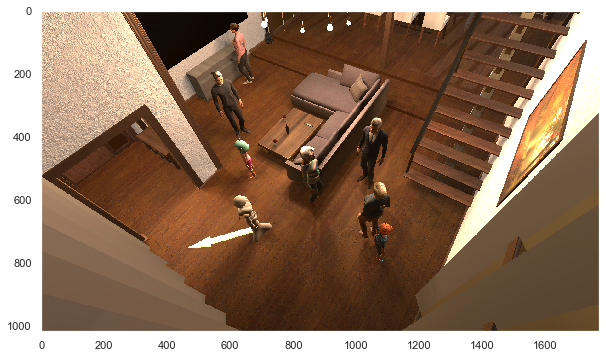

| Action                             |   Prediction |   Epistemic uncertainty |   Aleatoric uncertainty |
|------------------------------------+--------------+-------------------------+-------------------------|
| Vacuum cleaning                    |     0.800977 |                0.740336 |                 2.25407 |
| Mopping the floor                  |     1.49935  |                0.597783 |                 1.94925 |
| Carry warm food                    |     1.10198  |                0.638046 |                 2.02455 |
| Carry cold food                    |     1.81266  |                0.785263 |                 2.50897 |
| Carry drinks                       |     1.75799  |                0.486722 |                 3.01906 |
| Carry small objects (plates, toys) |     1.65823  |                0.450116 |                 2.4433  |
| Carry big objects (tables, chairs) |     0.963253 |                0.577675 |                 1.90281 |
| Starting conversation              |     2.8

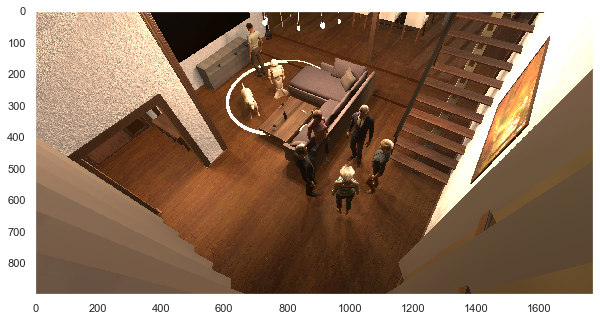

| Action                             |   Prediction |   Epistemic uncertainty |   Aleatoric uncertainty |
|------------------------------------+--------------+-------------------------+-------------------------|
| Vacuum cleaning                    |      2.56809 |                1.12005  |                 3.46843 |
| Mopping the floor                  |      2.62653 |                1.05973  |                 1.63143 |
| Carry warm food                    |      3.2952  |                0.896301 |                 2.01307 |
| Carry cold food                    |      3.76295 |                1.0802   |                 3.71086 |
| Carry drinks                       |      3.3237  |                1.19499  |                 3.70342 |
| Carry small objects (plates, toys) |      3.86995 |                1.13829  |                 1.36355 |
| Carry big objects (tables, chairs) |      2.40441 |                1.09486  |                 1.27661 |
| Cleaning (Picking up stuff)        |      3.

In [27]:
# Prediction and uncertainty for some scenes:
scene_number = 800

# Arrow
arrow = 1
stamp_arrow = data[arrow]['test']['x'][scene_number,0].cpu().detach().numpy()
# Outputs
Prediction_arrow = np.mean(mean_arrow, axis = 2)[scene_number]
Aleatoric_arrow = np.mean(np.exp(log_var_arrow), axis = 2)[scene_number]
Epistemic_arrow = (np.mean(np.square(mean_arrow), axis = 2) - np.square(np.mean(mean_arrow, axis = 2)))[scene_number]
i = 0
# Table
table = []
for question in questions[arrow]:
    table.append([question, Prediction_arrow[i], Epistemic_arrow[i], Aleatoric_arrow[i]])
    i += 1
print("Scene number: ", int(stamp_arrow))
# Print image
if features.loc[features['Stamp'] == int(stamp_arrow)].empty:
    image_path = '/Users/jonastjomsland/Dissertation/' + features.loc[features['Stamp'] == str(int(stamp_arrow))]['File Path'].values[0]
else:
    image_path = '/Users/jonastjomsland/Dissertation/' + features.loc[features['Stamp'] == int(stamp_arrow)]['File Path'].values[0]
img = mpimg.imread(image_path)
plt.figure(figsize = (10,12))
plt.rcParams["axes.grid"] = False
imgplot = plt.imshow(img)
plt.show()
# Print table
print(tabulate(table, headers= ['Action', 'Prediction', 'Epistemic uncertainty', 'Aleatoric uncertainty'], tablefmt='orgtbl'))

# circle
arrow = 0
stamp_circle = data[arrow]['test']['x'][scene_number,0].cpu().detach().numpy()
Prediction_circle = np.mean(mean_circle, axis = 2)[scene_number]
Aleatoric_circle = np.mean(np.exp(log_var_circle), axis = 2)[scene_number]
Epistemic_circle = (np.mean(np.square(mean_circle), axis = 2) - np.square(np.mean(mean_circle, axis = 2)))[scene_number]
i = 0
table = []
for question in questions[arrow]:
    table.append([question, Prediction_circle[i], Epistemic_circle[i], Aleatoric_circle[i]])
    i += 1
print()
print("Scene number: ", int(stamp_circle))
# Print image
if features.loc[features['Stamp'] == int(stamp_circle)].empty:
    image_path = '/Users/jonastjomsland/Dissertation/' + features.loc[features['Stamp'] == str(int(stamp_circle))]['File Path'].values[0]
else:
    image_path = '/Users/jonastjomsland/Dissertation/' + features.loc[features['Stamp'] == int(stamp_circle)]['File Path'].values[0]
img = mpimg.imread(image_path)
plt.figure(figsize = (10,12))
plt.rcParams["axes.grid"] = False
imgplot = plt.imshow(img)
plt.show()
print(tabulate(table, headers= ['Action', 'Prediction', 'Epistemic uncertainty', 'Aleatoric uncertainty'], tablefmt='orgtbl'))


In [26]:
print(data[1]['test']['x'].shape)

torch.Size([946, 30])
